In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE
from sklearn.linear_model import LinearRegression

# Open data and create the geo-data-frame
cal_housing = fetch_california_housing(as_frame=True)
df = pd.concat([cal_housing.data,
                cal_housing.target],
               axis=1)
gdf = gpd.GeoDataFrame(
    df ,
    geometry = gpd.points_from_xy(df.Longitude,
                                  df.Latitude))

Nous avons chargé les données dans un data_frame, que nous avons converti en geo-dataframe. Une colunne a été rajouté à `gdf` qui correspond à la géométrie de chaque élément: ici des points.
Dans la suite, nous allons découper notre jeux de données en deux (car `train_size=0.5`) jeux, que nous allons utiliser un pour l'entrainement et un pour le test de notre modèle.

In [2]:
# Split the data into train and test data set
gdf_train, gdf_test = train_test_split(gdf,
                                       train_size=0.5,
                                       random_state=10)

In [3]:
print(gdf_train.shape)
print(gdf_train.columns)

(10320, 10)
Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'MedHouseVal', 'geometry'],
      dtype='object')


Notre geo-dataframe a 10 colonnes, la dernière correspond à la géometrie, et l'avant dernière correspond à la variable que nous voulons prédire (output variable).

Le découpage en deux jeux d'entrainement est aléatoire, et l'effet aléatoire est controlé par la variable `random_state` dans la fonction `train_test_split`. Pour mesurer cet effet lors du cacul de l'erreur de prediction (ici, la MSE) sur le jeux de tests, nous allons calculer cette MSE pour différent découpage, obtenue avec un `random_state` différent.

In [4]:
INPUT_FEATURES = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Longitude', 'Latitude']
OUTPUT_FEATURE = ["MedHouseVal"]
mse = []
for random_state in range(50):
    gdf_train, gdf_test = train_test_split(df,
                                           train_size=0.5,
                                           random_state=random_state)
    model = LinearRegression()
    model.fit(gdf_train.loc[:, INPUT_FEATURES], 
              gdf_train.loc[:, OUTPUT_FEATURE])
    yp = model.predict(gdf_test.loc[:, INPUT_FEATURES])
    mse.append(MSE(gdf_test.loc[:, OUTPUT_FEATURE], yp))

La variable `mse` contient toute les MSE calculées sur les 50 répétitions. Pour nous faire un idée de sa variabilité en fonction du `random_state`, nous pouvons déjà regarer quelque indicateurs statistique

In [5]:
print(f"Moyenne: {np.mean(mse):.2f}, median: {np.median(mse):.2f}, dev. stand.: {np.std(mse):.2f}, min: {np.min(mse):.2f}, max: {np.max(mse):.2f}")

Moyenne: 0.60, median: 0.53, dev. stand.: 0.44, min: 0.50, max: 3.68


On peut déjà voir que la valeur max est très grande par rapport a la valeur moyenne et à la valeur médianne. Pour visualiser cette variabilité, nous pouvons utiliser les [https://en.wikipedia.org/wiki/Box_plot](boxplot).

(0.4, 0.8)

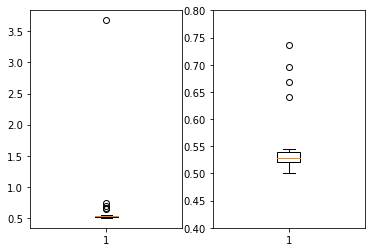

In [6]:
pfig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].boxplot(mse)
axs[1].boxplot(mse)
axs[1].set_ylim(0.4, 0.8)

On peut constater que ces 50 répitions qu'en moyenne, le découpage a un effet limité mais significatif, avec une variation d'environ 10%. Cependant, pour certain découpage "pathologique", la MSE peut être beaucoup plus élevés, comme le montre la figure ci-dessus de gauche.

Pour un modèle lineaire, on peut regarder les paramètres optimaux et essayer de les interpréter. Pour cela, on va ici simpement visualiser les valeurs des coefficient du modèle.

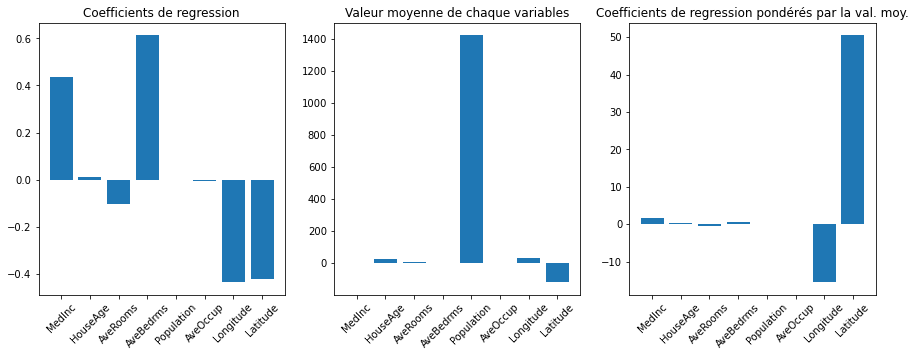

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharex=True)

axs[0].bar(range(8), model.coef_.squeeze())
axs[0].set_title("Coefficients de regression")
axs[0].set_xticks(range(8), INPUT_FEATURES, rotation=45)

axs[1].bar(range(8), gdf_train.iloc[:,:-2].mean())
axs[1].set_title("Valeur moyenne de chaque variables")
axs[1].set_xticks(range(8), INPUT_FEATURES, rotation=45)

axs[2].bar(range(8), model.coef_.squeeze()*gdf_train.iloc[:,:-2].mean())
axs[2].set_title("Coefficients de regression pondérés par la val. moy.")
axs[2].set_xticks(range(8), INPUT_FEATURES, rotation=45)

La figure de droite semblent indiquer que la `Longitude` et la `Latitude` sont les variables les plus importantes. Pour le vérifier, nous allons refaire les entrainements en n'utilisant que ces variables ou en les excluants

In [8]:
FEATURES = [['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup'], ['Longitude', 'Latitude']]
MSE_train, MSE_test = [], []
for features in FEATURES:
    mse_train, mse_test = [], []
    for random_state in range(100):
        gdf_train, gdf_test = train_test_split(df,
                                               train_size=0.5,
                                               random_state=random_state)
        model = LinearRegression()
        model.fit(gdf_train.loc[:,features], gdf_train.loc[:,OUTPUT_FEATURE])
        
        # MSE train
        yp = model.predict(gdf_train.loc[:, features])
        mse_train.append(MSE(gdf_train.loc[:,OUTPUT_FEATURE], yp))
        
        # MSE test
        yp = model.predict(gdf_test.loc[:, features])
        mse_test.append(MSE(gdf_test.loc[:, OUTPUT_FEATURE], yp))
        
    MSE_train.append(mse_train)
    MSE_test.append(mse_test)

(0.5, 1.5)

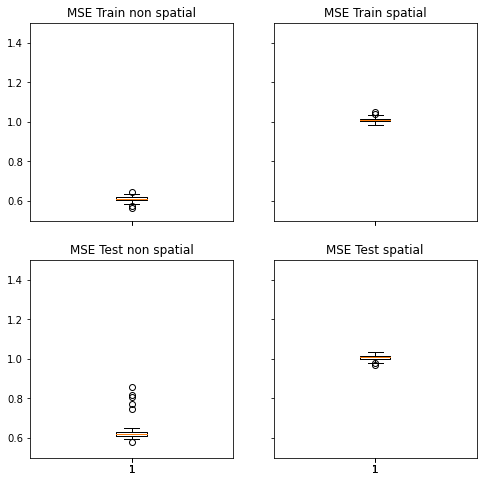

In [9]:
fig,axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharey=True, sharex=True)
axs[0, 0].boxplot(MSE_train[0])
axs[0, 0].set_title("MSE Train non spatial")
axs[1, 0].boxplot(MSE_test[0])
axs[1, 0].set_title("MSE Test non spatial")
axs[0, 1].boxplot(MSE_train[1])
axs[0, 1].set_title("MSE Train spatial")
axs[1, 1].boxplot(MSE_test[1])
axs[1, 1].set_title("MSE Test spatial")
axs[1, 1].set_ylim(0.5, 1.5)

Contrairement à ce que nous avions observé, ce sont bien les variables autre que les coordonnées spatiales qui permettent la meilleur prédiction. Cependant, c'est l'utilisation des deux (spatial & non-spatial) qui permet la meilleur prediction.